## Workflow for data retrieval 

This notebook describes the workflow to retriev and process publication data from DImensions Analytics with the goal of comparing historical developments of the Max Planck Society to other research institutions as well as national and global developments. 

The analysis is published with the title: 

    Exploring institutional trends with Dimensions: 
    A comparative bibliometric analysis of the production of the Max Planck Society, 1966-2004

If the queries have been previously finished running, go ahead to section __Analysis__ and run the routines from there onwards.

To rerun this notebook, you first need to setup a Google Biquery account with Dimensions Analytics and enter your project ID below. For details, see e.g. this [tutorial](https://bigquery-lab.dimensions.ai/tutorials/01-connection/) of Dimensions. 

In [1]:
import re
import math
from collections import defaultdict
import pandas as pd
import numpy as np
import scipy.signal
from google.cloud import bigquery

In [1]:
projectID = ""

In [ ]:
client = bigquery.Client(projectID)

## Defining the queries



This sets the time range of the analysis.

In [4]:
yearStart = 1945
yearEnd = 2005

In [5]:
outpath = "./data/"
respath = f"{outpath}/results/"

In [6]:
totalOutput = f"""
SELECT
  year, 
  COUNT(p.id) AS pubs_global,
FROM
  `dimensions-ai.data_analytics.publications` p
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article"
GROUP BY
  year
"""

In [7]:
distributionFORcodes = f"""
SELECT
  year,
  ARRAY_LENGTH(category_for.first_level.codes) AS FOR_1st_codeLen,
  ARRAY_LENGTH(category_for.second_level.codes) AS FOR_2nd_codeLen,
  COUNT(DISTINCT(p.id)) AS pubs_global
FROM
  `dimensions-ai.data_analytics.publications` p
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article"
GROUP BY
  year,
  FOR_1st_codeLen,
  FOR_2nd_codeLen
"""

In [8]:
def forCodeCountryLevel(levelString="first_level", noSecond=False):
    no2ndString = ''
    if levelString == "first_level" and noSecond is True:
        no2ndString = 'AND ARRAY_LENGTH(category_for.second_level.codes) = 0'
    retString = f"""SELECT
    year,
    cat,
    cnty,
    COUNT(DISTINCT(p.id)) AS pubs
FROM
    `dimensions-ai.data_analytics.publications` p
    LEFT JOIN UNNEST(category_for.{levelString}.codes) AS cat
    LEFT JOIN UNNEST(research_org_countries) AS cnty
WHERE
    year between {yearStart} AND {yearEnd} {no2ndString} and type = "article"
GROUP BY
    cat,
    year, 
    cnty
ORDER BY
    year,
    pubs,
    cat,
    cnty"""
    return retString

In [9]:
def FORquery(level=1, national=False, noSecond=False, yearStart=yearStart, yearEnd=yearEnd):
    no2ndString = ""
    nationalString = ""
    if level == 1:
        levelString = "first_level"
        if noSecond is True:
            no2ndString = 'AND ARRAY_LENGTH(category_for.second_level.codes) = 0'
    elif level == 2:
        levelString = "second_level"
    if national is not False:
        nationalString =  f'AND "{national}" in UNNEST(p.research_org_country_names)'
    retString =f"""SELECT
  year,
  CONCAT(cat.code, ' ', cat.name) as catfull,
  COUNT(DISTINCT(p.id)) AS pubs
FROM
  `dimensions-ai.data_analytics.publications` p
  LEFT JOIN UNNEST(category_for.{levelString}.full) AS cat
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article" {nationalString} {no2ndString}
GROUP BY
  year,
  catfull
ORDER BY
  year"""
    return retString

In [10]:
def FORqueryParentORG(parentGridID="grid.4372.2", level=1, noSecond=False, yearStart=yearStart, yearEnd=yearEnd):
    no2ndString = ""
    if level == 1:
        levelString = "first_level"
        if noSecond is True:
            no2ndString = 'AND ARRAY_LENGTH(category_for.second_level.codes) = 0'
    elif level == 2:
        levelString = "second_level"
    retString =f"""SELECT
  year,
  CONCAT(cat.code, ' ', cat.name) as catfull,
  COUNT(DISTINCT(p.id)) AS pubs
FROM
  `dimensions-ai.data_analytics.publications` p
  LEFT JOIN UNNEST(category_for.{levelString}.full) AS cat
WHERE
  year BETWEEN {yearStart} AND {yearEnd} AND "{parentGridID}" in UNNEST(p.research_orgs) {no2ndString} and type = "article"
GROUP BY
  year,
  catfull
ORDER BY
  year"""
    return retString

In [11]:
def FORqueryORG(parentGridID="grid.4372.2", level=1, noSecond=False, yearStart=yearStart, yearEnd=yearEnd):
    no2ndString = ""
    if level == 1:
        levelString = "first_level"
        if noSecond is True:
            no2ndString = 'AND ARRAY_LENGTH(category_for.second_level.codes) = 0'
    elif level == 2:
        levelString = "second_level"
    retString =f"""WITH hierarchy AS (

  SELECT
    g.id AS parent,
    g.name AS parent_name,
    children,
    g2.name AS children_name,
  FROM
    `dimensions-ai.data_analytics.grid` g
  CROSS JOIN
    UNNEST(organization_recursive_child_ids) AS children
  INNER JOIN
    `dimensions-ai.data_analytics.grid` g2
  ON
    g2.id = children 
  WHERE
    g.id="{parentGridID}"

)

SELECT
  hierarchy.parent_name AS institution,
  hierarchy.children_name AS subinst,
  year,
  CONCAT(cat.code, ' ', cat.name) as catfull,
  COUNT(DISTINCT p.id) as pubs
FROM
  hierarchy 
INNER JOIN
  `dimensions-ai.data_analytics.publications` p
  on hierarchy.children in UNNEST(p.research_orgs)
  LEFT JOIN UNNEST(category_for.{levelString}.full) AS cat
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article" {no2ndString}
GROUP BY
  institution,
  subinst,
  year,
  catfull
ORDER BY
  year"""
    return retString

In [12]:
outputPerMPI = f"""
WITH hierarchy AS (

  SELECT
    g.id AS parent,
    g.name AS parent_name,
    children,
    g2.name AS children_name,
  FROM
    `dimensions-ai.data_analytics.grid` g
  CROSS JOIN
    UNNEST(organization_recursive_child_ids) AS children
  INNER JOIN
    `dimensions-ai.data_analytics.grid` g2
  ON
    g2.id = children 
  WHERE
    g.id="grid.4372.2"

)

SELECT
  hierarchy.parent_name AS institution,
  hierarchy.children_name AS subinst,
  hierarchy.children AS subinstGRID,
  year,
  COUNT(DISTINCT p.id) as pubs
FROM
  hierarchy 
INNER JOIN
  `dimensions-ai.data_analytics.publications` p
  on hierarchy.children in UNNEST(p.research_orgs)
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article"
GROUP by
  year,
  institution,
  subinst,
  subinstGRID
"""

In [13]:
totalOutputMPIs = f"""
WITH hierarchy AS (

  SELECT
    g.id AS parent,
    g.name AS parent_name,
    children,
    g2.name AS children_name,
  FROM
    `dimensions-ai.data_analytics.grid` g
  CROSS JOIN
    UNNEST(organization_recursive_child_ids) AS children
  INNER JOIN
    `dimensions-ai.data_analytics.grid` g2
  ON
    g2.id = children 
  WHERE
    g.id="grid.4372.2"

)

SELECT
  year,
  p.id
FROM
  hierarchy 
INNER JOIN
  `dimensions-ai.data_analytics.publications` p
  on hierarchy.children in UNNEST(p.research_orgs)
WHERE
  year BETWEEN {yearStart} AND {yearEnd} and type = "article"
GROUP by
  year,
  p.id
"""

In [14]:
totalOutputMPGonly = f"""
SELECT
  year,
  p.id
FROM
  `dimensions-ai.data_analytics.publications` p
WHERE
  year BETWEEN {yearStart} AND {yearEnd} AND "grid.4372.2" in UNNEST(p.research_orgs) and type = "article"
GROUP by
  year,
  p.id
"""

In [15]:
totalOutputGermany = f"""
SELECT
  year,
  COUNT(DISTINCT(p.id)) AS pubs
FROM
  `dimensions-ai.data_analytics.publications` p
WHERE
  year BETWEEN {yearStart} AND {yearEnd} AND "Germany" in UNNEST(p.research_org_country_names) and type = "article"
GROUP BY
  year
ORDER BY
  year ASC,
  pubs
"""

## Running the queries

### Baseline total

In [16]:
query_job = client.query(totalOutput)
results = query_job.result()
res = [x for x in results]

In [17]:
dfyear = pd.DataFrame([x.values() for x in res], columns=['year','total'])

<AxesSubplot:xlabel='year'>

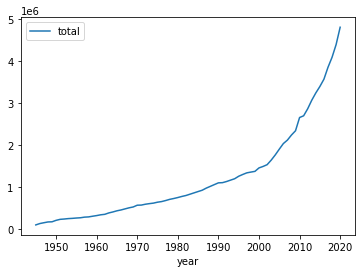

In [18]:
dfyear.sort_values('year').set_index('year').plot()

In [19]:
dfyear.to_csv(f'{outpath}baseline_total_publications.csv',index=False)

### Baseline MPG

In [20]:
query_job = client.query(totalOutputMPIs)
results = query_job.result()
res = [x for x in results]

In [21]:
query_job2 = client.query(totalOutputMPGonly)
results2 = query_job2.result()
res2 = [x for x in results2]

In [22]:
dfMPGyear = pd.DataFrame([x.values() for x in res2], columns=['year','total'])
dfMPIyear = pd.DataFrame([x.values() for x in res], columns=['year','total'])

In [23]:
baseline_MPG = pd.concat([dfMPGyear,dfMPIyear]).drop_duplicates(subset="total").groupby('year').size()

In [24]:
baseline_MPG.to_csv(f'{outpath}baseline_MPG_publications.csv')

### FOR codes and affiliation data

In [25]:
query_job = client.query(forCodeCountryLevel('first_level'))
results = query_job.result()
res = [x for x in results]

In [26]:
query_job2 = client.query(forCodeCountryLevel('second_level'))
results2 = query_job2.result()
res2 = [x for x in results2]

In [27]:
query_job3 = client.query(forCodeCountryLevel('first_level', noSecond=True))
results3 = query_job3.result()
res3 = [x for x in results3]

In [28]:
dfForAffil_1st = pd.DataFrame([x.values() for x in res], columns=['year','forname', 'country', 'total'])

In [29]:
dfForAffil_1st.to_csv(f'{outpath}FORCode_1st_Country_Counts.csv', index=False)

In [30]:
dfForAffil_2nd = pd.DataFrame([x.values() for x in res2], columns=['year','forname', 'country', 'total'])

In [31]:
dfForAffil_2nd.to_csv(f'{outpath}FORCode_2nd_Country_Counts.csv', index=False)

In [32]:
dfForAffil_1st_no2nd = pd.DataFrame([x.values() for x in res3], columns=['year','forname', 'country', 'total'])

#### 1st level

In [33]:
ret1st_1=[]
for yearcat, g0 in dfForAffil_1st.query('~forname.isna()').groupby(['year', 'forname']):
    ret1st_1.append(
        (yearcat[0], yearcat[1], g0.query('country.isna()').total.sum()/g0.total.sum())
    )
ret1st_2=[]
for yearcat, g0 in dfForAffil_1st.query('~forname.isna()').groupby(['year']):
    ret1st_2.append(
        (yearcat, g0.query('country.isna()').total.sum()/g0.total.sum())
    )

In [34]:
pd.DataFrame(ret1st_1, columns=['year', 'forcode', 'relation']).to_csv(f'{outpath}FOR_1st_NoCountry_over_Total_per_ForCode_excluding_NoFOR.csv', index=False)

In [35]:
pd.DataFrame(ret1st_2, columns=['year', 'relation']).to_csv(f'{outpath}FOR_1st_NoCountry_over_TotalAllForCodes_excluding_NoFOR.csv', index=False)

#### 2nd level

In [36]:
ret2nd_1=[]
for yearcat, g0 in dfForAffil_2nd.query('~forname.isna()').groupby(['year', 'forname']):
    ret2nd_1.append(
        (yearcat[0], yearcat[1], g0.query('country.isna()').total.sum()/g0.total.sum())
    )
ret2nd_2=[]
for yearcat, g0 in dfForAffil_2nd.query('~forname.isna()').groupby(['year']):
    ret2nd_2.append(
        (yearcat, g0.query('country.isna()').total.sum()/g0.total.sum())
    )

In [37]:
pd.DataFrame(ret2nd_2, columns=['year', 'relation']).to_csv(f'{outpath}FOR_2nd_NoCountry_over_TotalAllForCodes_excluding_NoFOR.csv', index=False)

#### 1st without 2nd level

In [38]:
ret1st_no2nd_1=[]
for yearcat, g0 in dfForAffil_1st_no2nd.query('~forname.isna()').groupby(['year', 'forname']):
    ret1st_no2nd_1.append(
        (yearcat[0], yearcat[1] + '00', g0.query('country.isna()').total.sum()/g0.total.sum())
    )
ret1st_no2nd_2=[]
for yearcat, g0 in dfForAffil_1st_no2nd.query('~forname.isna()').groupby(['year']):
    ret1st_no2nd_2.append(
        (yearcat, g0.query('country.isna()').total.sum()/g0.total.sum())
    )

In [39]:
pd.concat([pd.DataFrame(ret2nd_1, columns=['year', 'forcode', 'relation']), pd.DataFrame(ret1st_no2nd_1, columns=['year', 'forcode', 'relation'])]).to_csv(f'{outpath}FOR_2nd_NoCountry_over_Total_per_ForCode_excluding_NoFOR.csv', index=False)

In [40]:
pd.DataFrame(ret1st_no2nd_2, columns=['year', 'relation']).to_csv(f'{outpath}FOR_1st_without_2nd_NoCountry_over_TotalAllForCodes_excluding_NoFOR.csv', index=False)

### Distribution of FOR codes length

In [41]:
query_job = client.query(distributionFORcodes)
results = query_job.result()
res = [x for x in results]

In [42]:
dfdistFORLen = pd.DataFrame([x.values() for x in res], columns=['year','len1st', 'len2nd', 'total'])

### FOR codes queries

In [43]:
for comb in [
    (1,False,False), (2, False, False), (1,False, True), 
    (1, "Germany", False), (2, "Germany", False),(1, "Germany", True),
    (1, "United States", False), (2, "United States", False),(1, "United States", True),
]:
    query = FORquery(level=comb[0], national=comb[1], noSecond=comb[2])
    query_job = client.query(query)
    results = query_job.result()
    res = [x for x in results]
    dfTemp = pd.DataFrame([x.values() for x in res], columns=['year','forname', 'total'])
    if comb[1] is False:
        org = 'global'
    else:
        org = comb[1]
    if comb[0] == 1:
        level = '1st'
    elif comb[0] == 2:
        level = '2nd'
    if comb[2] == True:
        ext = '_1st_without_2nd'
    else:
        ext = ''
    dfTemp.insert(0, 'org', org)
    dfTemp.to_csv(f'{outpath}FOR_{level}_{re.sub(" ", "_", org)}{ext}.csv', index=False)

### Institutional FOR code queries

In [44]:
for comb in [
    ('Max Planck Society','grid.4372.2', 1, False), ('Max Planck Society','grid.4372.2', 2, False), ('Max Planck Society','grid.4372.2', 1, True),
    ('University of Oxford', 'grid.4991.5', 1, False), ('University of Oxford', 'grid.4991.5', 2, False), ('University of Oxford', 'grid.4991.5', 1, True), 
    ('Harvard University', 'grid.38142.3c', 1, False), ('Harvard University', 'grid.38142.3c', 2, False), ('Harvard University', 'grid.38142.3c', 1, True), 
    ('University of California System','grid.30389.31', 1, False), ('University of California System','grid.30389.31', 2, False), ('University of California System','grid.30389.31', 1, True)
]:
    query = FORqueryParentORG(parentGridID=comb[1], level=comb[2], noSecond=comb[3])
    query_job = client.query(query)
    results = query_job.result()
    res = [x for x in results]
    dfTemp = pd.DataFrame([x.values() for x in res], columns=['year','forname', 'total'])
    if comb[2] == 1:
        level = '1st'
    elif comb[2] == 2:
        level = '2nd'
    if comb[3] == True:
        ext = '_1st_without_2nd'
    else:
        ext = ''
    dfTemp.insert(0, 'subinst', '')
    dfTemp.insert(0, 'institution', comb[0])
    query2 = FORqueryORG(parentGridID=comb[1], level=comb[2], noSecond=comb[3])
    query_job2 = client.query(query2)
    results2 = query_job2.result()
    res2 = [x for x in results2]
    dfTemp2 = pd.DataFrame([x.values() for x in res2], columns=['institution', 'subinst', 'year','forname', 'total'])
    dfTotal = pd.concat([dfTemp, dfTemp2])
    dfTotal.to_csv(f'{outpath}FOR_{level}_{re.sub(" ", "_", comb[0])}{ext}.csv', index=False)

### Output of MPIs

In [45]:
query_job = client.query(outputPerMPI)
results = query_job.result()
res = [x for x in results]

In [46]:
dfMPIoutput = pd.DataFrame([x.values() for x in res], columns=['institution','subinst', 'gridID', 'year', 'total'])

In [47]:
dfMPIoutput.to_csv(f'{outpath}Output_per_MPI.csv', index=False)

### Output of Germany

In [48]:
query_job = client.query(totalOutputGermany)
results = query_job.result()
res = [x for x in results]

In [49]:
dfGermanoutput = pd.DataFrame([x.values() for x in res], columns=['year', 'total'])

In [50]:
dfGermanoutput.to_csv(f'{outpath}Output_Germany.csv', index=False)